In [17]:
import json
import gzip
import numpy as np
import pandas as pd
from collections import Counter
from matplotlib import pyplot as plt

In [11]:
with open("../data/sentiment/train.json") as infile:
    data = json.load(infile)

In [13]:
df = pd.DataFrame(data=data)

In [14]:
df.head()

,text,start_char_pos,end_char_pos,important_span_text,sentiment
0,Epic Games has raised $2 billion in funding fr...,11,43,has raised $2 billion in funding,positive
1,The Halt is the best thing that’s happened to ...,16,42,best thing that’s happened,positive
2,#HelloFuture would just be augmented to #Hello...,13,41,would just be augmented to #,positive
3,A show of confidence that HBAR can stand on it...,31,63,can stand on its own as an asset,negative
4,": we want it, you need it!",0,13,": we want it,",positive


In [42]:
df["len"] = df.text.apply(lambda x: len(x))

<AxesSubplot:>

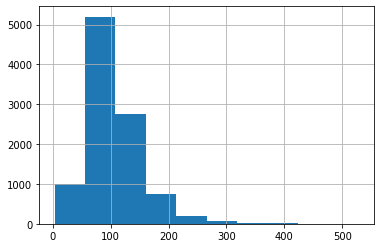

In [43]:
df.len.hist()

<AxesSubplot:>

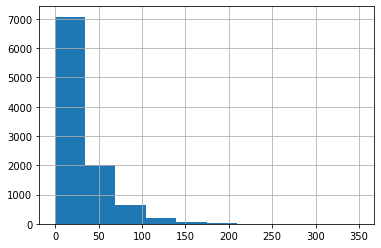

In [44]:
df.start_char_pos.hist()

<AxesSubplot:>

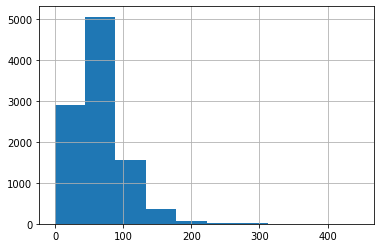

In [45]:
df.end_char_pos.hist()

In [15]:
df.sentiment.value_counts()

positive    5992
negative    4008
Name: sentiment, dtype: int64

In [22]:
c = {
    "positive": Counter(),
    "negative": Counter()
}

for row in df.itertuples():
    c[row.sentiment] += Counter(row.important_span_text.split(" "))

In [23]:
c["positive"].most_common(20)

[('a', 1328),
 ('the', 1160),
 ('of', 855),
 ('to', 835),
 ('is', 637),
 ('has', 622),
 ('and', 563),
 ('in', 379),
 ('rating', 364),
 ('its', 362),
 ('will', 287),
 ('quarterly', 272),
 ('an', 271),
 ('earnings', 256),
 ('up', 191),
 ('for', 189),
 ('potential', 182),
 ('shares', 179),
 ('be', 178),
 ('Get', 177)]

In [25]:
c["negative"].most_common(20)

[('a', 829),
 ('to', 788),
 ('the', 687),
 ('of', 629),
 ('has', 523),
 ('is', 492),
 ('not', 272),
 ('and', 266),
 ('are', 234),
 ('price', 202),
 ('down', 193),
 ('in', 191),
 ('be', 187),
 ('from', 177),
 ('their', 165),
 ('for', 158),
 ('market', 157),
 ('its', 153),
 ('rating', 145),
 ('been', 127)]

In [27]:
words = set(list(c["positive"].keys()) + list(c["negative"].keys()))

In [28]:
len(words)

10012

In [32]:
ratio = {
    "positive": Counter(),
    "negative": Counter()
}

for word in words:
    p, n = c["positive"].get(word, 0), c["negative"].get(word, 0)
    total = p + n
    if total < 50:
        continue
    ratio["positive"][word] = p / total
    ratio["negative"][word] = n / total

In [33]:
ratio["positive"].most_common(20)

[('grow', 1.0),
 ('topping', 1.0),
 ('“Buy”', 1.0),
 ('beating', 1.0),
 ('declared', 1.0),
 ('dividend,', 0.989247311827957),
 ('upside', 0.9888888888888889),
 ('quarterly', 0.9819494584837545),
 ('capitalization', 0.9818181818181818),
 ('raised', 0.9797979797979798),
 ('dividend', 0.9763779527559056),
 ('leading', 0.9714285714285714),
 ('recently', 0.97),
 ('average', 0.9642857142857143),
 ('Get', 0.9619565217391305),
 ('positive', 0.9571428571428572),
 ('Rating)', 0.9517241379310345),
 ('posted', 0.9384615384615385),
 ('data', 0.9325153374233128),
 ('strong', 0.9310344827586207)]

In [34]:
ratio["negative"].most_common(20)

[('lowered', 1.0),
 ('dropped', 1.0),
 ('below', 1.0),
 ('downgraded', 1.0),
 ('adverse', 1.0),
 ('loss', 1.0),
 ('no', 0.9855072463768116),
 ('missing', 0.984375),
 ('low', 0.9838709677419355),
 ('down', 0.965),
 ('cap', 0.9621212121212122),
 ('not', 0.9611307420494699),
 ('any', 0.896551724137931),
 ('ratio', 0.8888888888888888),
 ('cut', 0.8767123287671232),
 ('lower', 0.8461538461538461),
 ('had', 0.7739130434782608),
 ('or', 0.74),
 ('sell', 0.7333333333333333),
 ('estimates', 0.7297297297297297)]

In [35]:
from transformers import RobertaTokenizer, RobertaModel
tokenizer = RobertaTokenizer.from_pretrained('roberta-base')
model = RobertaModel.from_pretrained('roberta-base')

Downloading:   0%|          | 0.00/899k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/456k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/481 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/501M [00:00<?, ?B/s]

In [36]:
tokenizer(": we want it, you need it!")

{'input_ids': [0, 35, 52, 236, 24, 6, 47, 240, 24, 328, 2], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}

In [37]:
tokenizer(": we want it,")

{'input_ids': [0, 35, 52, 236, 24, 6, 2], 'attention_mask': [1, 1, 1, 1, 1, 1, 1]}

In [41]:
tokenizer.decode(35)

':'

In [48]:
def seq(a, b):
    return [x for x in range(len(a) + 1) if a[x:x+len(b)] == b]

In [126]:
X = []

for row in df.itertuples():
    encoded = tokenizer(row.text)
    txt = encoded["input_ids"]
    y = ["O"]
    l = 0
    p = "P" if row.sentiment == "positive" else "N"
    
    for token in txt[1:-1]:
        l += len(tokenizer.decode(token))
        
        if row.start_char_pos <= l <= row.end_char_pos + 1:
            y.append(p)
        else:
            y.append("O")
        
    y.append("O")
    encoded["label"] = y
    X.append(encoded)

In [127]:
X[0]

{'input_ids': [0, 39318, 636, 3100, 34, 1179, 68, 176, 325, 11, 1435, 31, 6366, 8, 5, 23863, 284, 4, 2], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], 'label': ['O', 'O', 'O', 'O', 'P', 'P', 'P', 'P', 'P', 'P', 'P', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']}

In [124]:
from transformers import DataCollatorForTokenClassification

In [132]:
data_collator = DataCollatorForTokenClassification(tokenizer=tokenizer)

In [129]:
from transformers import create_optimizer
from transformers import TFAutoModelForTokenClassification
import tensorflow as tf

In [133]:
tf_train_set = X.to_tf_dataset(
    columns=["attention_mask", "input_ids", "labels"],
    shuffle=True,
    batch_size=16,
    collate_fn=data_collator,
)

AttributeError: 'list' object has no attribute 'to_tf_dataset'

In [134]:
batch_size = 16
num_train_epochs = 3
num_train_steps = (len(X) // batch_size) * num_train_epochs

optimizer, lr_schedule = create_optimizer(
    init_lr=2e-5,
    num_train_steps=num_train_steps,
    weight_decay_rate=0.01,
    num_warmup_steps=0,
)

In [135]:
model = TFAutoModelForTokenClassification.from_pretrained("roberta-base", num_labels=3)

Downloading:   0%|          | 0.00/657M [00:00<?, ?B/s]

2022-04-24 15:37:12.258542: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-04-24 15:37:12.258560: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-04-24 15:37:12.258575: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (eka-thinkpad): /proc/driver/nvidia/version does not exist
2022-04-24 15:37:12.258754: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
All model checkpoint layers were used when initializing TFRobertaForTokenClassification.

Some layers 

In [136]:
model.compile(optimizer=optimizer)

In [137]:
model.fit(x=X, epochs=3)

ValueError: Failed to find data adapter that can handle input: (<class 'list'> containing values of types {"<class 'transformers.tokenization_utils_base.BatchEncoding'>"}), <class 'NoneType'>